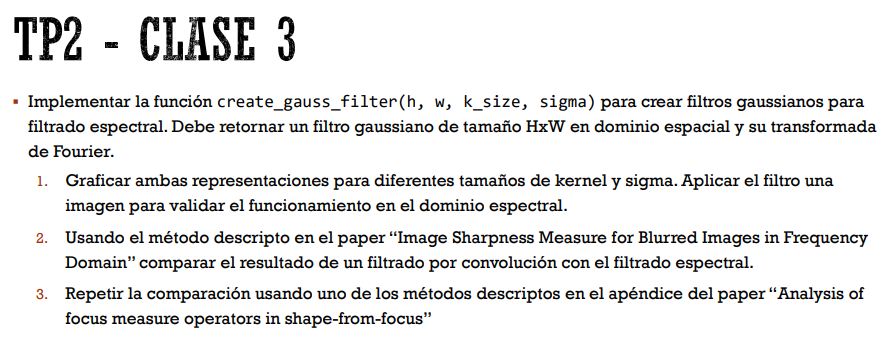

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Imagen original


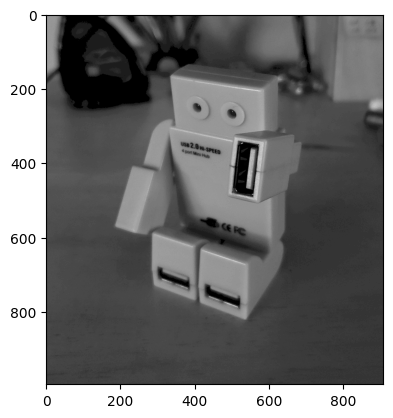

Tamaño imagen: (996, 908) pix


In [2]:
# Cargo una imagen para trabajar
     
# Cargo primera imagen
img = cv.imread('./CoordCrom_2.png', cv.IMREAD_GRAYSCALE)

print('Imagen original')
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

# Dimensión de la imagen
print(f'Tamaño imagen: {img.shape} pix')

In [3]:
# Creo un filtro gaussiano de H*W, tamaño de kernel k_size y desviación s
def create_gauss_filter(h, w, k_size, s):
    
    # Creo un kernel gaussiano de k_size y sigma:
    nucleo_g = cv.getGaussianKernel(ksize=k_size, sigma=s) 
    kernel = nucleo_g * nucleo_g.T

    # Crear una matriz de ceros de h,w
    filtro = np.zeros((h, w))

    # Calcular el índice de inicio y fin para los elementos centrales
    inicio_fila = (filtro.shape[0] - kernel.shape[0]) // 2
    fin_fila = inicio_fila + kernel.shape[0]
    inicio_col = (filtro.shape[1] - kernel.shape[1]) // 2
    fin_col = inicio_col + kernel.shape[1]

    # Sumo el kernel a los elementos centrales de canvas
    filtro[inicio_fila:fin_fila, inicio_col:fin_col] += kernel

    # Paso el filtro al dominio espectral
    kernel_tf = np.fft.fft2(filtro)
    return kernel, kernel_tf

*1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.*

In [4]:
# Defino un diccionario de filtros
filtros_gaussianos = {
    'filtro1': {'k_size': 5, 'sigma': 5},
    'filtro2': {'k_size': 5, 'sigma': 100},
    'filtro3': {'k_size': 25, 'sigma': 5},
    'filtro4': {'k_size': 25, 'sigma': 100},
    'filtro5': {'k_size': 51, 'sigma': 5},
    'filtro6': {'k_size': 51, 'sigma': 100}
}

# Creo los filtros
for nombre, params in filtros_gaussianos.items():
    filtros_gaussianos[nombre]['kernel'], filtros_gaussianos[nombre]['kernel_tf'] = create_gauss_filter(img.shape[0], 
                                                                                                        img.shape[1], 
                                                                                                        params['k_size'], 
                                                                                                        params['sigma'])

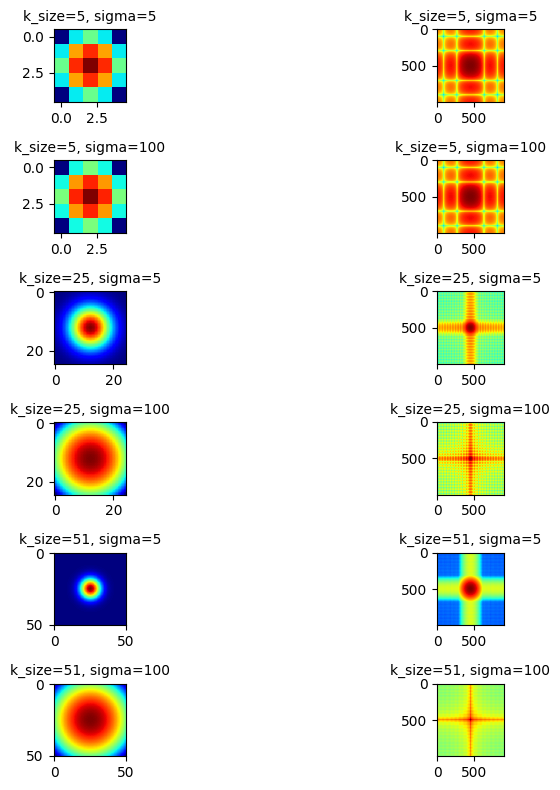

In [5]:
# Número de filas y columnas para el gráfico
num_filas = len(filtros_gaussianos)  
num_columnas = 2

# Grafico con subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(10, 8))

# Itero sobre el diccionario
for i, (nombre, dicc) in enumerate(filtros_gaussianos.items()):
    fila = i # Calcula la fila actual
    columna = 0  # Calcula la columna actual
    axs[fila, columna].imshow(dicc['kernel'], cmap='jet') 
    axs[fila, columna].set_title(f"k_size={dicc['k_size']}, sigma={dicc['sigma']}", fontsize=10)
    columna = 1
    # Ploteo la transformada centrada
    axs[fila, columna].imshow(20*np.log(np.abs(np.fft.fftshift(dicc['kernel_tf']))).astype('float64'), cmap='jet') 
    axs[fila, columna].set_title(f"k_size={dicc['k_size']}, sigma={dicc['sigma']}", fontsize=10)                                
                                 
# Ploteo
plt.tight_layout()
plt.show() 

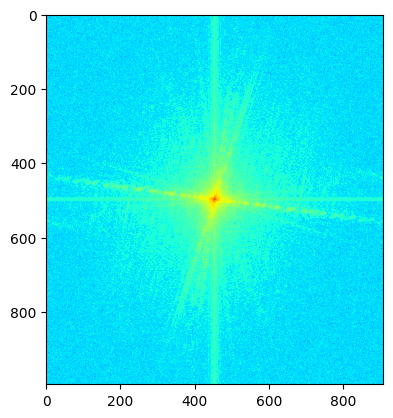

In [6]:
# Obtengo la transformada centrada de la imagen y ploteo
img_t = np.fft.fft2(img)

# Ploteo utilizando el modulo y centrado
plt.figure()
plt.imshow(20*np.log(np.abs(np.fft.fftshift(img_t))).astype('float64'), cmap='jet')
plt.show()

In [7]:
# Aplico los filtros

# Creo una función que descentra, elimina residuo complejo y descentra
def inversa(imagen):
    antitransformada = np.fft.ifft2(imagen)
    reales = np.real(antitransformada)
    inversa_shift = np.fft.ifftshift(reales)
    return inversa_shift

for i, (nombre, dicc) in enumerate(filtros_gaussianos.items()):
    filtros_gaussianos[nombre]['img_filt'] = inversa(img_t * dicc['kernel_tf'])

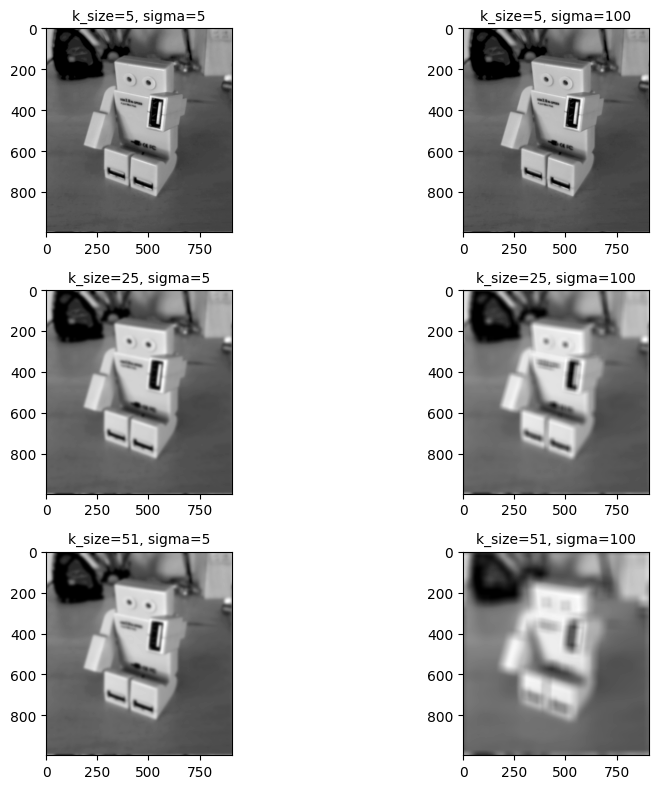

In [8]:
# Ploteo

# Número de filas y columnas para el gráfico
num_filas = int(np.ceil(len(filtros_gaussianos) / 2))
num_columnas = 2

# Grafico con subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(10, 8))

# Itero sobre el diccionario
for i, (nombre, dicc) in enumerate(filtros_gaussianos.items()):
    fila = i // num_columnas
    columna = i % num_columnas
    axs[fila, columna].imshow(dicc['img_filt'], cmap='gray') 
    axs[fila, columna].set_title(f"k_size={dicc['k_size']}, sigma={dicc['sigma']}", fontsize=10)                          

# Ploteo
plt.tight_layout()
plt.show() 

A mayor desviación y tamaño del kernel gaussiano utilizado, mayor es el efecto de desenfoque de la imagen.

Se puede observar en la imagen transformada y centrada del kernel gaussiano que existe una región central con dos franjas marcadas, una de frecuencias y una de armónicos, se visualizan así porque tienen valores numéricos mayores. Cuanto mayor es el tamaño del kernel o el valor de la desviación, menor es el tamaño de la región central y menor es el ancho de las franjas. Debido a la existencia de estas franjas, al aplicar el filtro se escala en mayor medida las frecuencias centrales, que en esta visualización son las bajas frecuencias. Así, el filtro funciona en forma similar a un pasabajos.

*2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.*

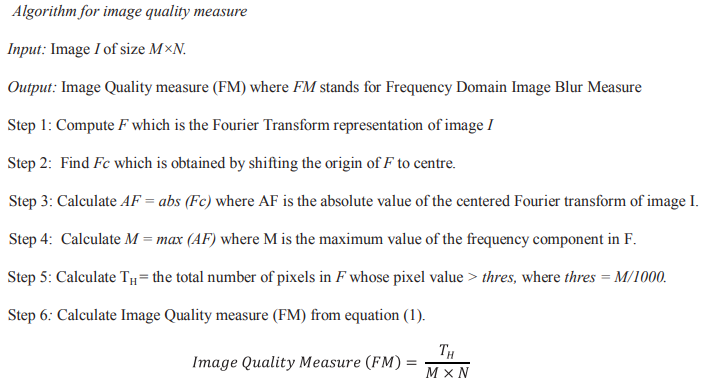

In [9]:
# Creo una función que tome una imagen y me devuelva la métrica.
def Image_Quality_Measure(imagen):
    
    # Step 1: Compute F which is the Fourier Transform representation of image I.
    F = np.fft.fft2(imagen)
    # Step 2: Find Fc which is obtained by shifting the origin of F to centre. 
    Fc = np.fft.fftshift(F)
    # Step 3: Calculate AF = abs(Fc). 
    AF = np.abs(Fc)
    # Step 4: Calculate M = max(AF).
    M = np.max(AF)
    # Step 5: Calculate TH = F-value > thres, where thres = M/1000.
    thres = M/1000
    TH = np.sum(F > thres)
    # Step 6: Calculate Image Quality Measure from equation FM = TH / (M * N). 
    FM = TH / img.size
    return FM

Un menor valor de la métrica FM implica un mayor desenfoque.

Para un filtro gaussiano convolucional, modifico sucesivamente el tamaño del kernel y la desviación y evalúo la métrica.

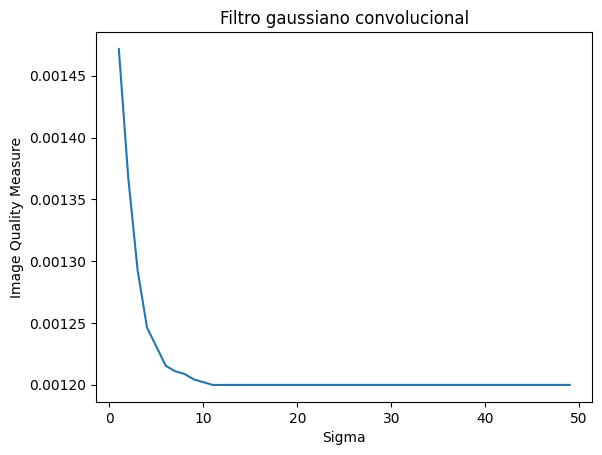

In [10]:
# Modifico la desviación manteniendo el tamaño del kernel
desviacion = [i for i in range(1,50)]
FM_desv = []
for sigma in desviacion:
    FM_desv.append(Image_Quality_Measure(cv.GaussianBlur(img, ksize=(11, 11), sigmaX=sigma,  sigmaY=sigma)))

# Ploteo
plt.plot(desviacion, FM_desv)
plt.xlabel('Sigma')
plt.ylabel('Image Quality Measure')
plt.title('Filtro gaussiano convolucional')
plt.show()

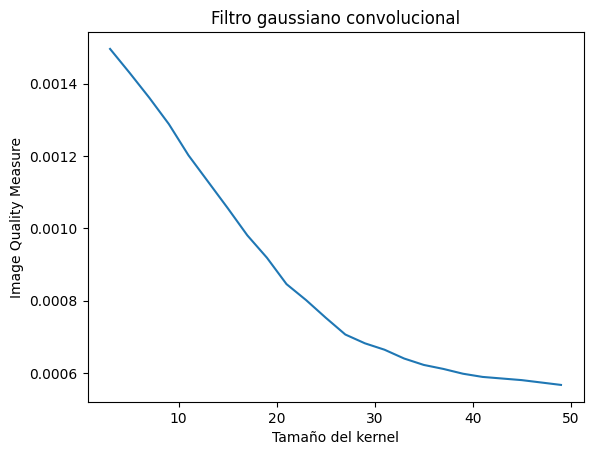

In [11]:
# Modifico el tamaño del kernel manteniendo la desviacion
k_size = [i for i in range(3, 51) if i % 2 != 0]
FM_k = []
for k in k_size:
    FM_k.append(Image_Quality_Measure(cv.GaussianBlur(img, ksize=(k, k), sigmaX=10,  sigmaY=10)))

# Ploteo
plt.plot(k_size, FM_k)
plt.xlabel('Tamaño del kernel')
plt.ylabel('Image Quality Measure')
plt.title('Filtro gaussiano convolucional')
plt.show()

En el filtrado gaussiano incrementar el sigma o el tamaño del kernel implica aumentar el desenfoque.

Evalúo en forma similar el filtrado espectral.

In [12]:
# Creo una función para el filtrado espectral
def filtrado_gaussiano_espectral(imagen, k, sigma):
    tf = np.fft.fft2(imagen)
    kernel, kernel_tf = create_gauss_filter(tf.shape[0], tf.shape[1], k_size=k, s=sigma)
    img_filtrada = tf * kernel_tf
    img_modificada = inversa(img_filtrada)
    return img_modificada

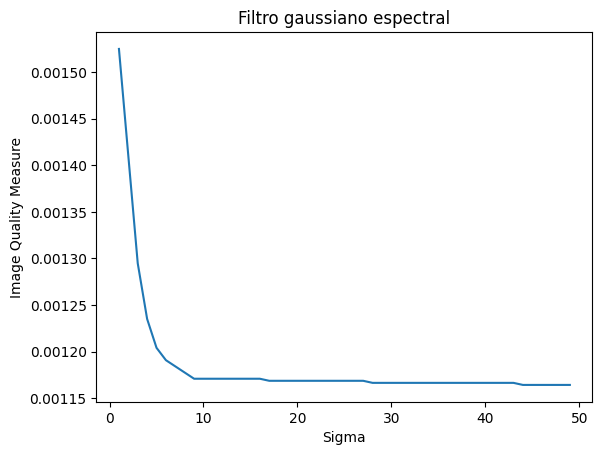

In [13]:
# Modifico la desviación manteniendo el tamaño del kernel
desviacion = [i for i in range(1,50)]
FM_desv = []
for sigma in desviacion:
    FM_desv.append(Image_Quality_Measure(filtrado_gaussiano_espectral(img, 11, sigma)))

# Ploteo
plt.plot(desviacion, FM_desv)
plt.xlabel('Sigma')
plt.ylabel('Image Quality Measure')
plt.title('Filtro gaussiano espectral')
plt.show()

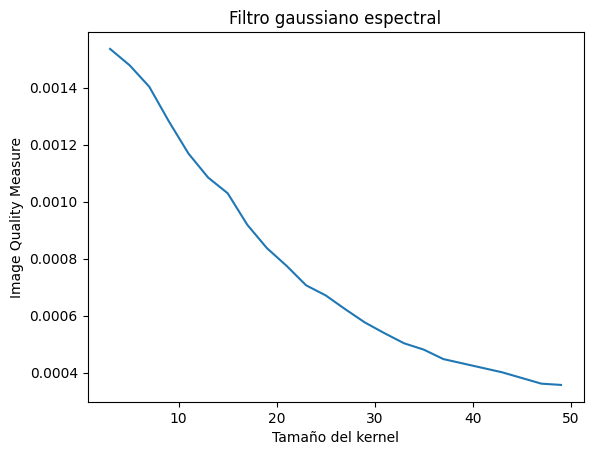

In [14]:
# Modifico el tamaño del kernel manteniendo la desviacion
k_size = [i for i in range(3, 51) if i % 2 != 0]
FM_k = []
for k in k_size:
    FM_k.append(Image_Quality_Measure(filtrado_gaussiano_espectral(img, k, 25)))

# Ploteo
plt.plot(k_size, FM_k)
plt.xlabel('Tamaño del kernel')
plt.ylabel('Image Quality Measure')
plt.title('Filtro gaussiano espectral')
plt.show()

Se observan métricas muy parecidas con ambos métodos, con valores levemente menores para el filtrado gaussiano espectral. La ventaja del filtrado espectral es que en general requiere una menor cantidad de operaciones para realizarlo. La cantidad de operaciones necesarias depende del método utilizado para obtener la transformada de Fourier y del tamaño del kernel para el caso convolucional, de todas formas se puede afirmar que en general requiere menos operaciones el filtrado espectral, aspecto que puede ser relevante en imágenes de gran tamaño o al procesar una gran cantidad de imagenes.

*3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”*

Repito la comparación utilizando el método de energía laplaciana.

In [15]:
# A.17. Laplacian energy
def Laplacian_Energy(img):
    
    # Aplico el laplaciano a una imagen y calculo el cuadrado de la intensidad resultante
    delta_I = cv.Laplacian(img, ddepth=1, ksize=5)
    # Cálculo la suma al cuadrado
    phi = np.sum(delta_I.astype(int)**2)
    return phi

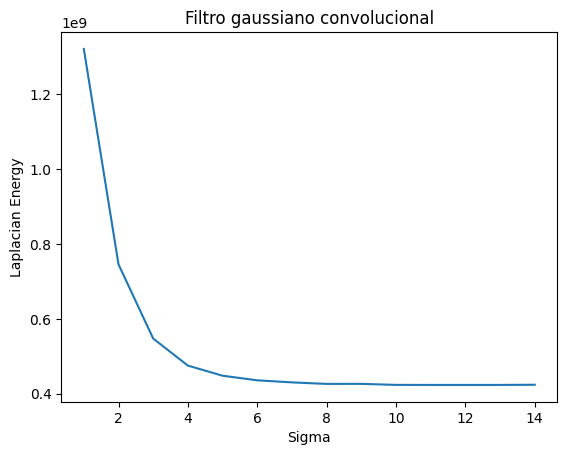

In [16]:
# Modifico la desviación manteniendo el tamaño del kernel
desviacion = [i for i in range(1,15)]
FM_desv = []
for sigma in desviacion:
    FM_desv.append(Laplacian_Energy(cv.GaussianBlur(img, ksize=(11, 11), sigmaX=sigma,  sigmaY=sigma)))

# Ploteo
plt.plot(desviacion, FM_desv)
plt.xlabel('Sigma')
plt.ylabel('Laplacian Energy')
plt.title('Filtro gaussiano convolucional')
plt.show()

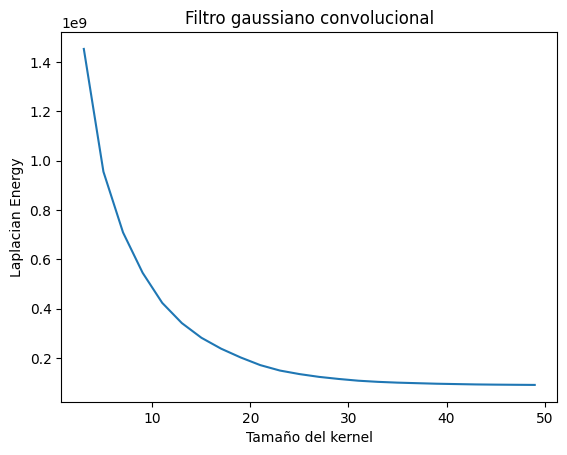

In [17]:
# Modifico el tamaño del kernel manteniendo la desviacion
k_size = [i for i in range(3, 51) if i % 2 != 0]
FM_k = []
for k in k_size:
    FM_k.append(Laplacian_Energy(cv.GaussianBlur(img, ksize=(k, k), sigmaX=10,  sigmaY=10)))

# Ploteo
plt.plot(k_size, FM_k)
plt.xlabel('Tamaño del kernel')
plt.ylabel('Laplacian Energy')
plt.title('Filtro gaussiano convolucional')
plt.show()

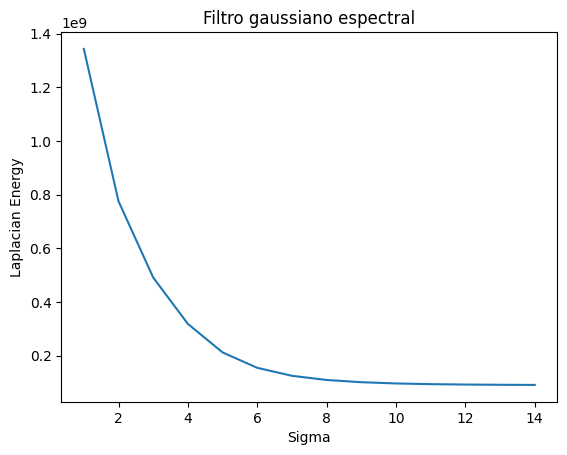

In [18]:
# Modifico la desviación manteniendo el tamaño del kernel
desviacion = [i for i in range(1,15)]
FM_desv = []
for sigma in desviacion:
    FM_desv.append(Laplacian_Energy(filtrado_gaussiano_espectral(img, 25, sigma)))

# Ploteo
plt.plot(desviacion, FM_desv)
plt.xlabel('Sigma')
plt.ylabel('Laplacian Energy')
plt.title('Filtro gaussiano espectral')
plt.show()

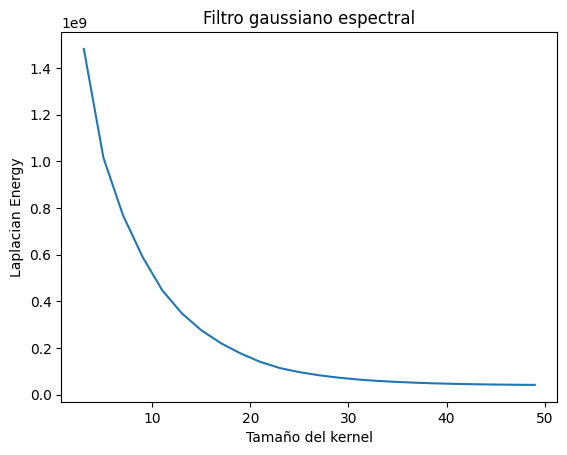

In [19]:
# Modifico el tamaño del kernel manteniendo la desviacion
k_size = [i for i in range(3, 51) if i % 2 != 0]
FM_k = []
for k in k_size:
    FM_k.append(Laplacian_Energy(filtrado_gaussiano_espectral(img, k, 10)))

# Ploteo
plt.plot(k_size, FM_k)
plt.xlabel('Tamaño del kernel')
plt.ylabel('Laplacian Energy')
plt.title('Filtro gaussiano espectral')
plt.show()

Al aumentar el tamaño del kernel gaussiano o su desviación, aumenta el desenfoque. Al hacerlo, la energía laplaciana disminuye. Este efecto se comprende si se considera al laplaciano como una medida de los cambios drásticos de intensidad. Estos cambios disminuyen al aumentar el desenfoque.
Las métricas son levemente menores para el filtrado espectral, en forma similar a lo observado con la métrica FM.